Prediccion de precios de cryptos. Usando protocolo 2 (normalizacion de ventanas en vez de normalizacion global).

Pucheta Mauro.


CARGA DE DATOS


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
from sklearn.preprocessing import MinMaxScaler

while not os.path.exists('datos_1h_limpios_V1.csv'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
### load in and normalize the dataset

dataset = np.genfromtxt('datos_1h_limpios_V1.csv', delimiter=',')
#datos tiene la forma Instancia X (date,timestamp(de la fecha),Open,	High,	Low,	Close,	Volume From,	Volume To)
#datos_1h tiene la forma timestamp,Open,High, Low,Close. volume from, volume to no es necesario la timestamp para predecir, pero si para plotear
#una alternativa es usar pandas.read_csv(file) directamente y puedo trabajar con los labels.

dataset=dataset[::-1] #lo invierto de una, porque si no el elemento 0 es lo mas actual

In [0]:
training_factor=0.7 # con 0.6 el 60% del total va para training



timestamp=dataset[:,0] 
dataset=dataset[:,1:] #le saco timestamps, para mejor ordenamiento

openPrice=dataset[:,0]
high=dataset[:,1]
low=dataset[:,2]
close=dataset[:,3]

volumeFrom=dataset[:,4]
volumeTo=dataset[:,5]

FEATURES=6 #esto es mas que nada el numero de columnas distintas, son caracteristicas de los valores

"""
openPrice=openPrice[::-1]
high=high[::-1]
low=low[::-1]
volumeFrom=volumeFrom[::-1]
volumeto=volumeTo[::-1]

close=close[::-1]
timestamp=timestamp[::-1] #invierto, porque las timestamps quedaban al revez

"""


train_test_frontera=int(len(close)*training_factor) #establezco la frontera de acuerdo al total de los datos y el porcentaje indicado en training_factor
while((train_test_frontera%32)!=0): #habia un problema si los datos no se podian ddividir en 32 por el batch size de las LSTM
  train_test_frontera+=1

#print(dataset[:,:]) #ver en el excel que los datos estan bien

datos_train=dataset[:train_test_frontera,:] #parto los datos de train con todos los datos, open,high,low,close
datos_test=dataset[train_test_frontera:,:]

objetivo=3 #quiero predecir el close, que es la columna 4 del dataset
datosObjetivo=dataset[:,objetivo]



In [0]:
WINDOW_SIZE=8
'''
en cuantos pasos anteriores me baso para predecir, si los datos venian de a dias,
window_size=7 me indica que me baso en los datos de la semana anterior para predecir
'''

PASOS_A_PREDECIR=1


def normalizarWindow(scaler,datos, porcionX,porcionY):
    scaler.fit(datos.reshape(-1,1))
    nuevoX=scaler.transform(porcionX.reshape(-1,1))
    nuevoY=scaler.transform(porcionY.reshape(-1,1))
    return nuevoX,nuevoY
  
def desnormalizarData(scaler,data):
    return scaler.inverse_transform(data) #o sea, puedo cambiar el scaler. 
  
def separarEnWindows(datos, windowSize,pasosFuturos,target):
  x=[]
  y=[]
  scaler= MinMaxScaler()
  
  for i in range(0,len(datos)-pasosFuturos-windowSize):
      
      nuevoX=[]
      nuevoY=[]
      
      for feature in range(0,FEATURES): #desde open hasta volumeTo
        _x,_y=normalizarWindow(scaler,datos[i:i+windowSize+pasosFuturos,feature],datos[i:i+windowSize,feature],datos[i+windowSize:i+windowSize+pasosFuturos,feature]) #_x, _y son ventanas de windowSize
    
        nuevoX.append(_x)
        nuevoY.append(_y)
    
      nuevoX=np.swapaxes(nuevoX,0,1)
     
      x.append(nuevoX)
      y.append(nuevoY)

      
  
  
  x=np.asarray(x)
  
  x.shape=np.shape(x)[0:3]#son ventanas de window_size
 
  y=np.asarray(y) #el output es un valor, que es el valor de prediccion de cierre
  y.shape=np.shape(y)[0:2]
  
  return x,y

x_train=[]
y_train=[]
x_test=[]
y_test=[]



x_train,y_train=separarEnWindows(datos_train,WINDOW_SIZE,PASOS_A_PREDECIR,objetivo)
x_test,y_test=separarEnWindows(datos_test,WINDOW_SIZE,PASOS_A_PREDECIR,objetivo)


In [4]:
print(x_train.shape)

(6551, 8, 6)


In [5]:
from keras.layers import Dense, LSTM, Input, Bidirectional, Conv1D,Flatten,BatchNormalization, Dropout, TimeDistributed, Activation,Lambda,RNN,GRU, RepeatVector
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
#HIPERPARAMETROS



BATCH_SIZE=256
EPOCHS=1500 #un ideal fue obtenido en los 400 epochs
OPTIMIZER= RMSprop(lr=0.005, rho=0.9, epsilon=1e-08, decay=1e-6)
LOSS='mean_squared_error'

UNITS=WINDOW_SIZE*3

METRICS=['cosine_proximity','mean_squared_error']

stopping=EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=1500, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

i = Input(shape=(WINDOW_SIZE,FEATURES))

#l = Bidirectional(LSTM(UNITS,unroll=True,return_sequences=True))(i)
l = LSTM(UNITS,unroll=True,return_sequences=True)(i)
#l = Dropout(0.25)(l)
l = LSTM(UNITS,unroll=True,return_sequences=True)(l)
d=  LSTM(FEATURES)(l)





model= Model(inputs=i,outputs=d)
model.summary()
model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
h=None




Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8, 6)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 24)             2976      
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 24)             4704      
_________________________________________________________________
lstm_3 (LSTM)                (None, 6)                 744       
Total params: 8,424
Trainable params: 8,424
Non-trainable params: 0
_________________________________________________________________


Train on 6551 samples, validate on 2784 samples
Epoch 1/1500
6551/6551 [==============================] - 4s 660us/step - loss: 0.1498 - cosine_proximity: -0.7715 - mean_squared_error: 0.1498 - val_loss: 0.1227 - val_cosine_proximity: -0.8124 - val_mean_squared_error: 0.1227
Epoch 2/1500
6551/6551 [==============================] - 1s 97us/step - loss: 0.0985 - cosine_proximity: -0.8611 - mean_squared_error: 0.0985 - val_loss: 0.0936 - val_cosine_proximity: -0.8611 - val_mean_squared_error: 0.0936
Epoch 3/1500
6551/6551 [==============================] - 1s 97us/step - loss: 0.0891 - cosine_proximity: -0.8686 - mean_squared_error: 0.0891 - val_loss: 0.0915 - val_cosine_proximity: -0.8622 - val_mean_squared_error: 0.0915
Epoch 4/1500
6551/6551 [==============================] - 1s 97us/step - loss: 0.0826 - cosine_proximity: -0.8758 - mean_squared_error: 0.0826 - val_loss: 0.1023 - val_cosine_proximity: -0.8657 - val_mean_squared_error: 0.1023
Epoch 5/1500
6551/6551 [===================

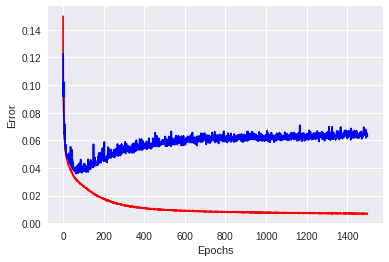

'\n#CARGAR MODELO\n\nfrom keras.models import model_from_json\nimport numpy\nimport os.path\n\nwhile not os.path.exists(\'model.json\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\nwhile not os.path.exists(\'model.h5\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\n          \njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\n\nprint("Loade

In [6]:
#ENTRENAR MODELO DESDE 0

"""
h=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=[x_test,y_test],callbacks=[stopping])
#GRAFICO DE PERDIDAS
v_loss = h.history['val_loss']
loss = h.history['loss']
plt.plot(range(len(loss)), loss, '-r')
plt.plot(range(len(v_loss)), v_loss, '-b')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()
"""
#CARGAR MODELO

from keras.models import model_from_json
import numpy
import os.path

while not os.path.exists('model.json'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

while not os.path.exists('model.h5'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

          
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")
loaded_model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
score = loaded_model.evaluate(x_test, y_test, verbose=0)
for i in range(0,len(loaded_model.metrics_names)):
  print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))
  
model=loaded_model



Lo siguiente es para abstraer el manejo de la entrada. El modelo necesita de 3 dimensiones, y poner a cada rato x.reshape(1,WINDOW_SIZE,1) dificultaba la lectura del codigo

In [0]:
def transformarA3D(datos,dim1,dim2,dim3):
  #la entrada del modelo requiere 3 dim
  return datos.reshape(dim1,dim2,dim3)



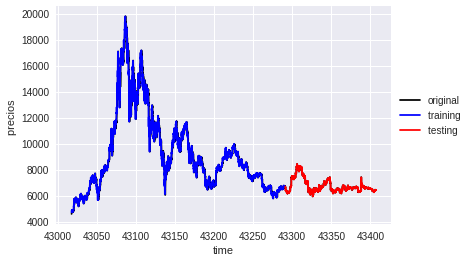

In [16]:
split_train = train_test_frontera - WINDOW_SIZE - PASOS_A_PREDECIR
split_test = train_test_frontera + WINDOW_SIZE + PASOS_A_PREDECIR

prediccion_train=[]
prediccion_test=[]

scaler=MinMaxScaler()
datos=dataset #datos sin normalizar
scalerObjetivo=None
for i in range(WINDOW_SIZE,len(datos_train)-PASOS_A_PREDECIR):
  x,y=[],[]
  for feature in range(0,FEATURES): #desde open hasta volumeTo
        
        porcion=datos_train[i-WINDOW_SIZE:i+PASOS_A_PREDECIR,feature] 
        porcionX=porcion[:-PASOS_A_PREDECIR]
       
        porcionY=porcion[-PASOS_A_PREDECIR:]
        _x,_y=normalizarWindow(scaler,porcion,porcionX,porcionY) #_x, _y son ventanas de windowSize
        x.append(_x)
        if(feature==objetivo):
          scalerObjetivo=scaler
          scaler=MinMaxScaler()

  
  x=np.asarray(x)
  x=np.swapaxes(x,0,1)
  x=transformarA3D(x,1,WINDOW_SIZE,FEATURES) 
  
 
  prediccion=model.predict(x) #tiene dimensiones 1xFeatures. debiera accederlo con [0,objetivo] pero es engorroso
  #prediccion=np.swapaxes(prediccion,0,1) #invierto, ahora es Featuresx1
  #prediccion=prediccion[objetivo]
  
  prediccion_train.append(desnormalizarData( scalerObjetivo,prediccion[0,objetivo]))
  
for i in range(WINDOW_SIZE,len(datos_test)-PASOS_A_PREDECIR):
  x,y=[],[]
  for feature in range(0,FEATURES): #desde open hasta volumeTo
        porcion=datos_test[i-WINDOW_SIZE:i+PASOS_A_PREDECIR,feature] 
        porcionX=porcion[:-PASOS_A_PREDECIR]
        porcionY=porcion[-PASOS_A_PREDECIR:]
        _x,_y=normalizarWindow(scaler,porcion,porcionX,porcionY) #_x, _y son ventanas de windowSize
        x.append(_x)
        if(feature==objetivo):
          scalerObjetivo=scaler
          scaler=MinMaxScaler()

  x=np.asarray(x)
  x=np.swapaxes(x,0,1)
  x=transformarA3D(x,1,WINDOW_SIZE,FEATURES) 
  
  prediccion=model.predict(x) #tiene dimensiones 1xFeatures. debiera accederlo con [0,objetivo] pero es engorroso
  #prediccion=np.swapaxes(prediccion,0,1)
  #prediccion=prediccion[objetivo]

  prediccion_test.append(desnormalizarData( scalerObjetivo,prediccion[0,objetivo]))

 
prediccion_train=np.asarray(prediccion_train)
prediccion_train=np.reshape(prediccion_train,prediccion_train.shape[0],prediccion_train.shape[1]) #debo convertirlo porque habia quedad INSTANCIAS X 1 X 1 y PLT.PLOT ESPERA INSTANCIAS X 1

prediccion_test=np.asarray(prediccion_test)
prediccion_test=np.reshape(prediccion_test,prediccion_test.shape[0],prediccion_test.shape[1])

plt.plot(timestamp,datosObjetivo,color='black') #son los datos originales del dataset
plt.plot(timestamp[:split_train],prediccion_train,color = 'b') #imprime lo predicho sobre los datos de training

# plot testing set prediction
plt.plot(timestamp[split_test:],prediccion_test,color = 'r') #imprime lo predicho sobre los datos de testing


plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','training ','testing '],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

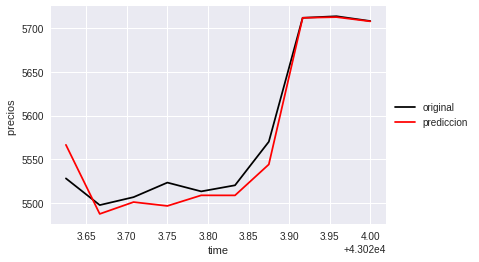

In [17]:
plt.clf()
comienzoPlot=150
finPlot=160


datos=dataset  #datos sin normalizar

plt.plot(timestamp[comienzoPlot:finPlot],datosObjetivo[comienzoPlot:finPlot],color='black') #son los datos originales del dataset




predicciones=[]

scaler=MinMaxScaler()
scalerObjetivo=None
sliceDatos=datos[comienzoPlot-WINDOW_SIZE:finPlot+PASOS_A_PREDECIR,:] #si quiero predecir 150 a 600. tomo de 150-ventana (para predecir 150) hasta 600+PASOS. 

for i in range(WINDOW_SIZE,len(sliceDatos)-PASOS_A_PREDECIR):
  x,y=[],[]
  #debo normalizar las ventanas para predecir
  
  for feature in range(0,FEATURES): #desde open hasta volumeTo
        porcion=sliceDatos[i-WINDOW_SIZE:i+PASOS_A_PREDECIR,feature] 
        porcionX=porcion[:-PASOS_A_PREDECIR]
        porcionY=porcion[-PASOS_A_PREDECIR:]
        _x,_y=normalizarWindow(scaler,porcion,porcionX,porcionY) #_x, _y son ventanas de windowSize
        x.append(_x)
        if(feature==objetivo):
          scalerObjetivo=scaler
          scaler=MinMaxScaler()

  x=np.asarray(x)
  x=np.swapaxes(x,0,1)
  x=transformarA3D(x,1,WINDOW_SIZE,FEATURES)
  
  prediccion=model.predict(x)
  predicciones.append(desnormalizarData( scalerObjetivo,prediccion[0,objetivo]))
 

predicciones=np.asarray(predicciones)
predicciones=np.reshape(predicciones,predicciones.shape[0],predicciones.shape[1])

plt.plot(timestamp[comienzoPlot:finPlot],predicciones,color = 'r') 






plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','prediccion'],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

In [18]:
i = Input(batch_shape=(1,WINDOW_SIZE,FEATURES))
#l = Bidirectional(LSTM(UNITS,unroll=True,return_sequences=True,stateful=True))(i)
l = LSTM(UNITS,unroll=True,return_sequences=True,stateful=True)(i)
l = LSTM(UNITS,unroll=True,return_sequences=True,stateful=True)(l)
d=  LSTM(FEATURES)(l)

nuevoModel= Model(inputs=i,outputs=d)
nuevoModel.summary()

nuevoModel.set_weights(model.get_weights())

nuevoModel.reset_states()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (1, 8, 6)                 0         
_________________________________________________________________
lstm_7 (LSTM)                (1, 8, 24)                2976      
_________________________________________________________________
lstm_8 (LSTM)                (1, 8, 24)                4704      
_________________________________________________________________
lstm_9 (LSTM)                (1, 6)                    744       
Total params: 8,424
Trainable params: 8,424
Non-trainable params: 0
_________________________________________________________________


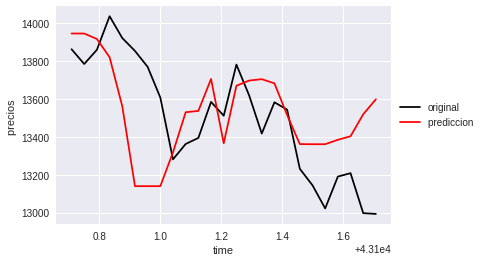

In [19]:
numPredicciones=25
frontera_predecir=2000
datos=dataset
scaler=MinMaxScaler()
scalerObjetivo=None


predicciones_recurrentes=np.empty((len(datos),FEATURES)) #instancias,n feature
predicciones_recurrentes[:,:]=datos[:,:] #toy manejando los datos tal cual estan en los datos, los datos puestos en ventanas son para training y predict. Aca estoy generando nuevos datos


nuevoModel.reset_states()

for i in range(0,numPredicciones):
  indiceDestinoStart=frontera_predecir+i
  indiceDestinoFin=frontera_predecir+i+PASOS_A_PREDECIR
  indiceSourceVentanaStart=frontera_predecir-WINDOW_SIZE-1+i
  indiceSourceVentanaFin=frontera_predecir+i
  for mod in range(0,FEATURES): #voy a iterar por cada feature, genero el dato nuevo correspondiente a cada feature basado en todas las features anteriores
    x,y=[],[]
    
    #hasta aca tengo ventanas, pero no estan normalizadas. Ademas, por cada nueva prediccion tengo que renormalizar
    
    for feature in range(0,FEATURES): 
      #desde open hasta volumeTo
      porcion=predicciones_recurrentes[indiceSourceVentanaStart:indiceSourceVentanaFin,feature] 

      porcionX=porcion[:-PASOS_A_PREDECIR]
      porcionY=porcion[-PASOS_A_PREDECIR:] #esto es similar a lo anterior, solo que porcionY luego se va a pisar por la nueva prediccion

      _x,_y=normalizarWindow(scaler,porcion,porcionX,porcionY) #_x, _y son ventanas de windowSize
      x.append(_x)
      if(feature==mod):
        scalerObjetivo=scaler
        scaler=MinMaxScaler()

    x=np.asarray(x)
    x=np.swapaxes(x,0,1)
    x=transformarA3D(x,1,WINDOW_SIZE,FEATURES)

   
    pred=nuevoModel.predict(x)
    predicciones_recurrentes[indiceDestinoStart:indiceDestinoFin,mod]=desnormalizarData(scalerObjetivo,pred[0,mod]) 
  
plt.clf()


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],datos[frontera_predecir:frontera_predecir+numPredicciones,objetivo],color='black') #son los datos originales del dataset


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],predicciones_recurrentes[frontera_predecir:frontera_predecir+numPredicciones,objetivo],color = 'r') 






plt.xlabel('time')
plt.ylabel('precios ')
plt.legend(['original','prediccion '],loc='center left', bbox_to_anchor=(1, 0.5))

figura = plt.gcf()
plt.show()

(9353, 6)


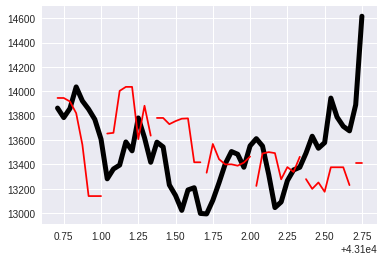

In [20]:
numPredicciones=50
frontera_predecir=2000

RESET=8

datos=dataset
scaler=MinMaxScaler()
scalerObjetivo=None

predicciones_recurrentes=np.empty((len(datos),FEATURES)) #instancias,n feature
predicciones_recurrentes[:,:]=datos[:,:] #toy manejando los datos tal cual estan en los datos, los datos puestos en ventanas son para training y predict. Aca estoy generando nuevos datos



  
print(predicciones_recurrentes.shape)

predicciones_plot=[]

for i in range(0,numPredicciones):
  
  indiceDestinoStart=frontera_predecir+i
  indiceDestinoFin=frontera_predecir+i+PASOS_A_PREDECIR
  indiceSourceVentanaStart=frontera_predecir-WINDOW_SIZE-1+i
  indiceSourceVentanaFin=frontera_predecir+i
  
  if((i%(WINDOW_SIZE))==0):
    predicciones_recurrentes[:,:]=datos[:,:] #reset de los datos para la proxima trend
    nuevoModel.reset_states()

  for mod in range(0,FEATURES): #voy a iterar por cada modelo generado
    x,y=[],[]
    
    
           
    for feature in range(0,FEATURES): 
      #desde open hasta volumeTo
   

      porcion=predicciones_recurrentes[indiceSourceVentanaStart:indiceSourceVentanaFin,feature] 

      porcionX=porcion[:-PASOS_A_PREDECIR]
      porcionY=porcion[-PASOS_A_PREDECIR:] #esto es similar a lo anterior, solo que porcionY luego se va a pisar por la nueva prediccion

      _x,_y=normalizarWindow(scaler,porcion,porcionX,porcionY) #_x, _y son ventanas de windowSize
      x.append(_x)
      if(feature==mod):
        scalerObjetivo=scaler
        scaler=MinMaxScaler()

    x=np.asarray(x)
    x=np.swapaxes(x,0,1)
    x=transformarA3D(x,1,WINDOW_SIZE,FEATURES)

    pred=nuevoModel.predict(x)
    pred=desnormalizarData(scalerObjetivo,pred[0,mod])
    predicciones_recurrentes[indiceDestinoStart:indiceDestinoFin,mod]=pred
   
    if(mod==objetivo):
      predicciones_plot.append(pred)


  

predicciones_plot=np.asarray(predicciones_plot).reshape(numPredicciones,1)

plt.clf()


plt.plot(timestamp[frontera_predecir:frontera_predecir+numPredicciones],datos[frontera_predecir:frontera_predecir+numPredicciones,objetivo],color='black',linewidth=5) #son los datos originales del dataset


split_pred=numPredicciones%RESET


for i in range(0,numPredicciones-split_pred,RESET):
  
  plt.plot(timestamp[frontera_predecir+i:frontera_predecir+i+RESET],predicciones_plot[i:i+RESET],color = 'r') 

plt.plot(timestamp[frontera_predecir+numPredicciones-split_pred:frontera_predecir+numPredicciones],predicciones_plot[numPredicciones-split_pred:numPredicciones],color = 'r') #printeo lo que faltaba que no entraba en las window


In [21]:
"""
#GUARDAR MODELO

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")


#despues poner que baje el archivo este "model.h5" que corre en esta maquina virtual que está corriendo
#el jupyter notebook. Se baja mediante el colab.download que use en la clase 3
from google.colab import files
files.download("model.h5")
files.download("model.json")
"""

Saved model to disk


In [14]:
"""
#CARGAR MODELO

from keras.models import model_from_json
import numpy
import os.path

while not os.path.exists('model.json'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

while not os.path.exists('model.h5'):
    #Si no está el archivo hay que subirlo. Solo para Google Colab!!
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

          
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")
loaded_model.compile(loss=LOSS,optimizer=OPTIMIZER,metrics=METRICS)
score = loaded_model.evaluate(x_test, y_test, verbose=0)
for i in range(0,len(loaded_model.metrics_names)):
  print("%s: %.2f%%" % (loaded_model.metrics_names[i], score[i]*100))
  
model=loaded_model
"""

'\n#CARGAR MODELO\n\nfrom keras.models import model_from_json\nimport numpy\nimport os.path\n\nwhile not os.path.exists(\'model.json\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\nwhile not os.path.exists(\'model.h5\'):\n    #Si no está el archivo hay que subirlo. Solo para Google Colab!!\n    from google.colab import files\n    uploaded = files.upload()\n    for fn in uploaded.keys():\n        print(\'User uploaded file "{name}" with length {length} bytes\'.format(name=fn, length=len(uploaded[fn])))\n\n          \njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\n\nprint("Loade